In [74]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

Combine the csv file of all clustered color profile and video metrics using the Video ID 

In [75]:
# Combine all cluster data and color profile percentage into one DataFrame
color_profile_data = pd.read_csv('Clustered_Color_Profile.csv')

# Load video engagement data
video_data = pd.read_csv('results_count_with_error.csv')

Get rid of the '.jpg' in the video ID in Clustered Color Profile

In [76]:
# Remove the .jpg extension from the VideoID in color_profile_data
color_profile_data['VideoID'] = color_profile_data['VideoID'].str.replace('.jpg', '')

# Check again after cleaning
print("\nCleaned Sample IDs from color_profile_data:")
print(color_profile_data['VideoID'].head())


Cleaned Sample IDs from color_profile_data:
0    2KMPO_X70aM
1    z4o7B7EqlyA
2    h5HvB2tun4Y
3    los0jDQ1JgQ
4    YZfG-QIjvt0
Name: VideoID, dtype: object


In [77]:
# Display the first few rows of both datasets
print("\nClustered Color Profile Data:")
print(color_profile_data.head())
print("\nNumber of rows and columns in text_data:", color_profile_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Clustered Color Profile Data:
       VideoID  cluster  Yellow  Orange   Red  Violet  Blue  Green  Black  \
0  2KMPO_X70aM        8    0.00    1.24  0.00   19.83  0.00    0.0  20.11   
1  z4o7B7EqlyA        1    2.94   13.90  0.27   16.88  0.71    0.0  19.03   
2  h5HvB2tun4Y        7    0.21    0.26  0.00   14.37  0.00    4.6   9.05   
3  los0jDQ1JgQ        2    0.00    0.16  9.44   12.52  0.00    0.0  28.79   
4  YZfG-QIjvt0        8    0.15    8.64  0.00   18.59  0.50    0.0   4.08   

   White  Brown  
0  10.86  47.96  
1  20.03  26.24  
2  49.74  21.77  
3  23.97  25.12  
4   6.84  61.20  

Number of rows and columns in text_data: (2946, 11)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  lZXDClzL8m8     4885860       75940           3507
1  XsWKvutlu8I     3545247       55237           1656
2  stMSVi5wI8k     3824080       67281           2274
3  b7HQU_--Qdw      596295       10123            831
4  zDwuJgLNJbc     4322068       74383           47

In [78]:
# Merge datasets on 'Video ID'
merged_data = pd.merge(color_profile_data, video_data, on='VideoID', how='inner')

# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID  cluster  Yellow  Orange   Red  Violet  Blue  Green  Black  \
0  2KMPO_X70aM        8    0.00    1.24  0.00   19.83  0.00    0.0  20.11   
1  z4o7B7EqlyA        1    2.94   13.90  0.27   16.88  0.71    0.0  19.03   
2  h5HvB2tun4Y        7    0.21    0.26  0.00   14.37  0.00    4.6   9.05   
3  los0jDQ1JgQ        2    0.00    0.16  9.44   12.52  0.00    0.0  28.79   
4  ChjJi3WLk4g        4    0.00    0.83  0.00   36.00  0.00    0.0  28.72   

   White  Brown  View Count  Like Count  Comment Count  
0  10.86  47.96       42832         864            129  
1  20.03  26.24       66954        3149            267  
2  49.74  21.77       25735        1263            190  
3  23.97  25.12        4613         177             11  
4  10.68  23.77       21976         420             24  

Number of rows and columns: (2448, 14)


## ANOVA

Collect Metric Data by Cluster

In [79]:
# Define which video metric columns to analyze
metric_columns_for_anova = ['View Count', 'Like Count', 'Comment Count']
print(f"Metrics selected for analysis: {', '.join(metric_columns_for_anova)}")

Metrics selected for analysis: View Count, Like Count, Comment Count


In [80]:
# Create a dictionary to store ANOVA results
anova_results = {}

# Display information about clusters
cluster_sizes = merged_data['cluster'].value_counts().sort_index()

print("## Color Cluster Summary ##")
print(f"Total videos: {len(merged_data)}")
print(f"Number of clusters: {len(cluster_sizes)}")
print("\nVideos per cluster:")
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size} videos")

## Color Cluster Summary ##
Total videos: 2448
Number of clusters: 9

Videos per cluster:
  Cluster 0: 479 videos
  Cluster 1: 363 videos
  Cluster 2: 105 videos
  Cluster 3: 155 videos
  Cluster 4: 372 videos
  Cluster 5: 50 videos
  Cluster 6: 69 videos
  Cluster 7: 341 videos
  Cluster 8: 514 videos


Looking and Removing Outliers

## Outlier Analysis ##

Metric: View Count
Original data points: 2448
After outlier removal: 2142
Outliers removed: 306 (12.5%)

Metric: Like Count
Original data points: 2448
After outlier removal: 2151
Outliers removed: 297 (12.1%)

Metric: Comment Count
Original data points: 2448
After outlier removal: 2201
Outliers removed: 247 (10.1%)


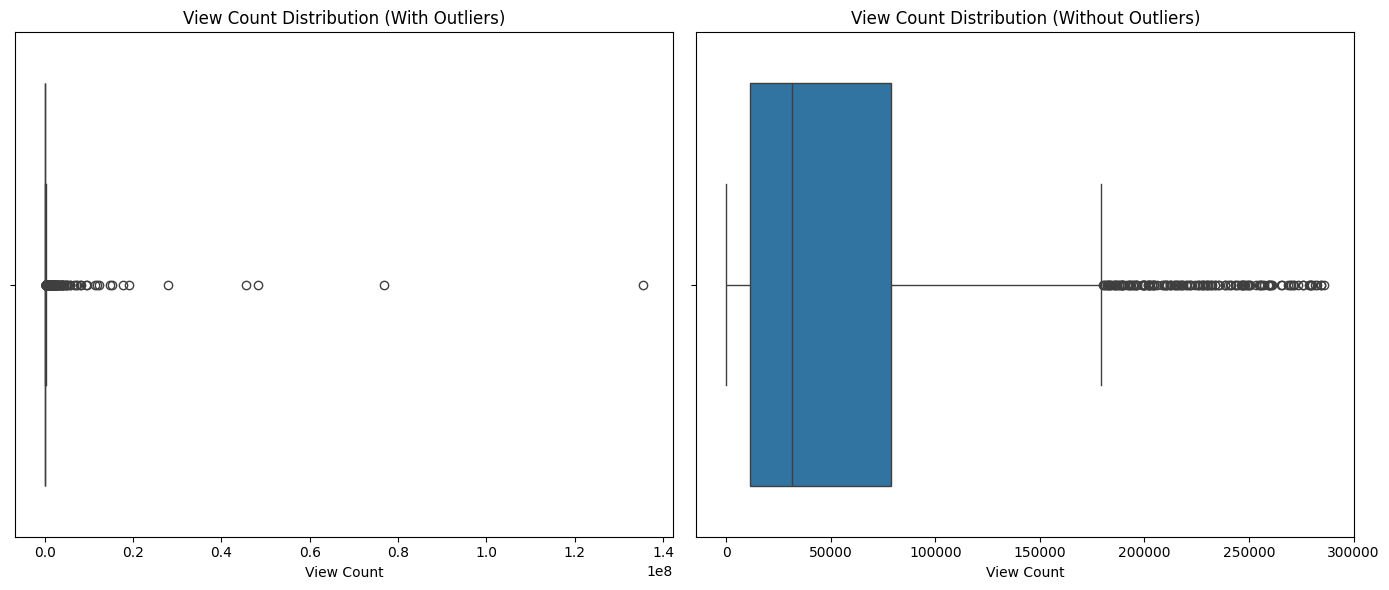

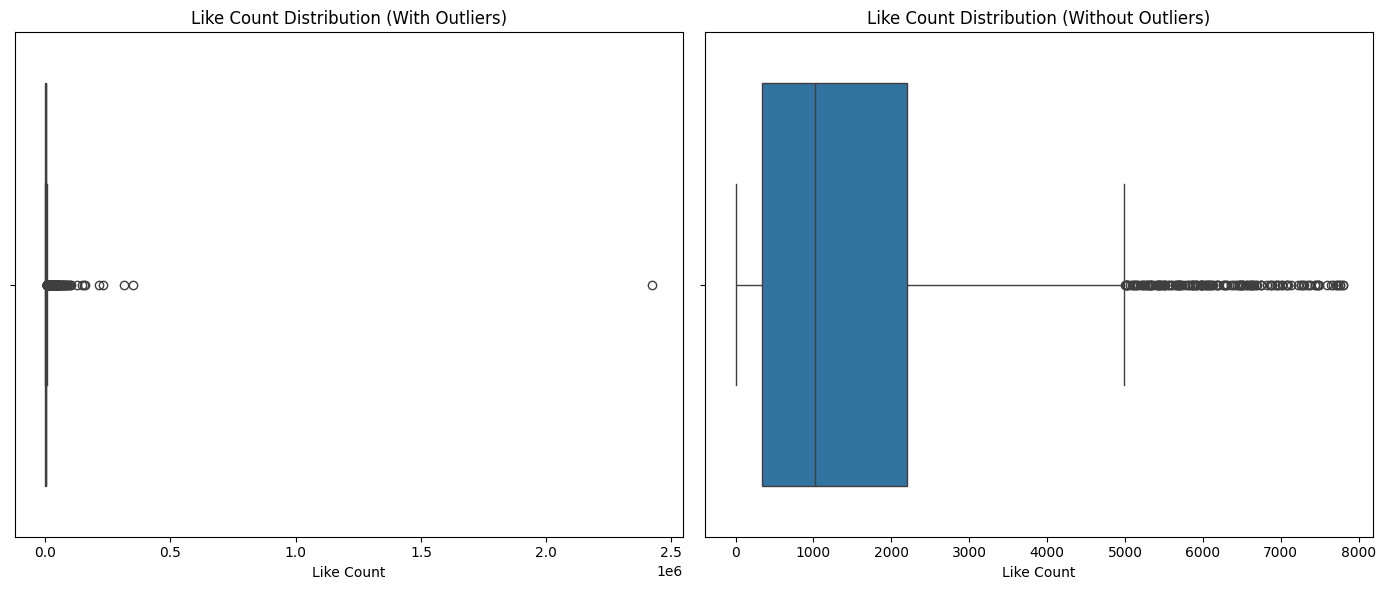

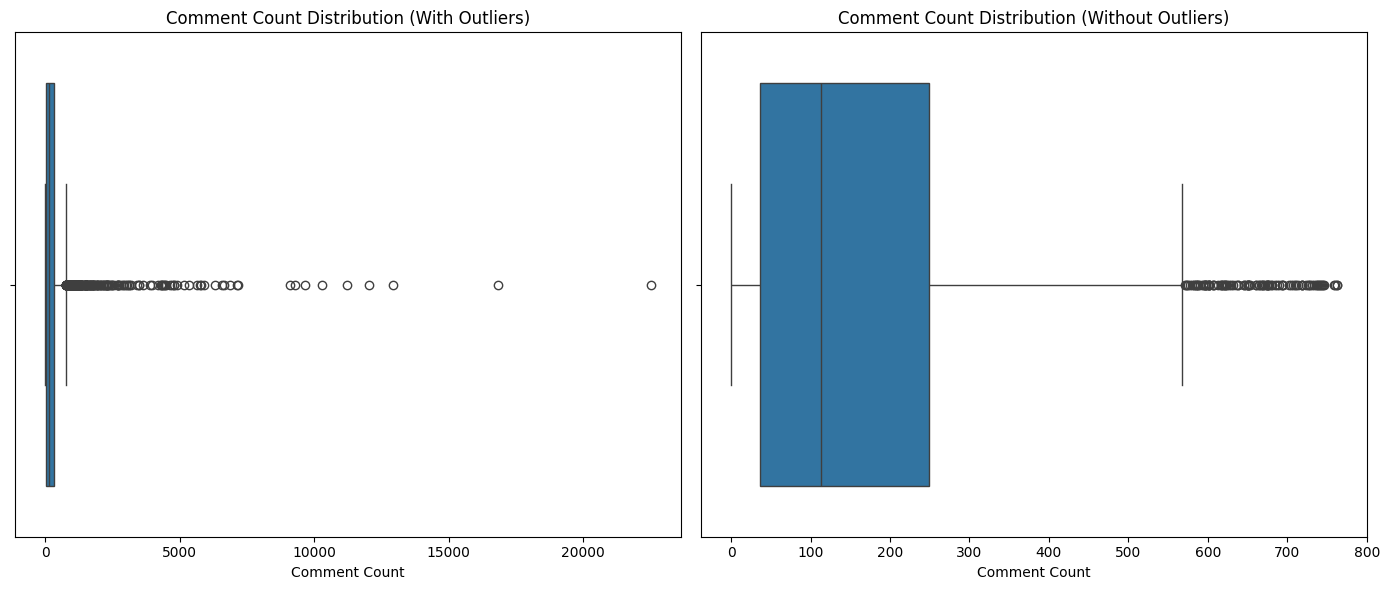

In [81]:
# Create function to identify and remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframe without outliers
    return df[~outlier_mask], df[outlier_mask]

print("## Outlier Analysis ##")

# Create clean versions of the dataset for each metric
clean_data = {}
outliers = {}

for metric in metric_columns_for_anova:
    clean_data[metric], outliers[metric] = remove_outliers(merged_data, metric)
    
    print(f"\nMetric: {metric}")
    print(f"Original data points: {len(merged_data)}")
    print(f"After outlier removal: {len(clean_data[metric])}")
    print(f"Outliers removed: {len(outliers[metric])} ({len(outliers[metric])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
for metric in metric_columns_for_anova:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Before outlier removal
    sns.boxplot(x=merged_data[metric], ax=ax1)
    ax1.set_title(f'{metric} Distribution (With Outliers)')
    
    # After outlier removal
    sns.boxplot(x=clean_data[metric][metric], ax=ax2)
    ax2.set_title(f'{metric} Distribution (Without Outliers)')
    
    plt.tight_layout()
    plt.show()

In [82]:
# Create lists to hold data for each metric grouped by cluster (without outliers)
views_by_cluster = []
likes_by_cluster = []
comments_by_cluster = []

# Group cleaned data by cluster
for cluster_id in sorted(merged_data['cluster'].unique()):
    # Get views data for this cluster
    cluster_views = clean_data['View Count'][clean_data['View Count']['cluster'] == cluster_id]['View Count'].values
    views_by_cluster.append(cluster_views)
    
    # Get likes data for this cluster
    cluster_likes = clean_data['Like Count'][clean_data['Like Count']['cluster'] == cluster_id]['Like Count'].values
    likes_by_cluster.append(cluster_likes)
    
    # Get comments data for this cluster
    cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == cluster_id]['Comment Count'].values
    comments_by_cluster.append(cluster_comments)
    
    # Print some info about the data we're using
    print(f"Cluster {cluster_id} (after outlier removal):")
    print(f"  Views: {len(cluster_views)} videos")
    print(f"  Likes: {len(cluster_likes)} videos")
    print(f"  Comments: {len(cluster_comments)} videos")
    
print("\nData successfully grouped by cluster for ANOVA analysis.")

Cluster 0 (after outlier removal):
  Views: 412 videos
  Likes: 409 videos
  Comments: 422 videos
Cluster 1 (after outlier removal):
  Views: 314 videos
  Likes: 308 videos
  Comments: 312 videos
Cluster 2 (after outlier removal):
  Views: 99 videos
  Likes: 99 videos
  Comments: 98 videos
Cluster 3 (after outlier removal):
  Views: 135 videos
  Likes: 134 videos
  Comments: 137 videos
Cluster 4 (after outlier removal):
  Views: 329 videos
  Likes: 333 videos
  Comments: 344 videos
Cluster 5 (after outlier removal):
  Views: 45 videos
  Likes: 46 videos
  Comments: 47 videos
Cluster 6 (after outlier removal):
  Views: 66 videos
  Likes: 66 videos
  Comments: 64 videos
Cluster 7 (after outlier removal):
  Views: 289 videos
  Likes: 289 videos
  Comments: 301 videos
Cluster 8 (after outlier removal):
  Views: 453 videos
  Likes: 467 videos
  Comments: 476 videos

Data successfully grouped by cluster for ANOVA analysis.


In [84]:
# Perform ANOVA test on View Count (with outliers removed)
anova_result_views = f_oneway(*views_by_cluster)

# Print results
print("## ANOVA Results for Views ##")
print(f"ANOVA F-statistic: {anova_result_views.statistic:.4f}")
print(f"p-value: {anova_result_views.pvalue:.4e}")

# Interpretation
alpha = 0.05
if anova_result_views.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in View Count between color clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in View Count between color clusters (p > {alpha}).")

## ANOVA Results for Views ##
ANOVA F-statistic: 7.1929
p-value: 1.9172e-09
RESULT: There are statistically significant differences in View Count between color clusters (p < 0.05).


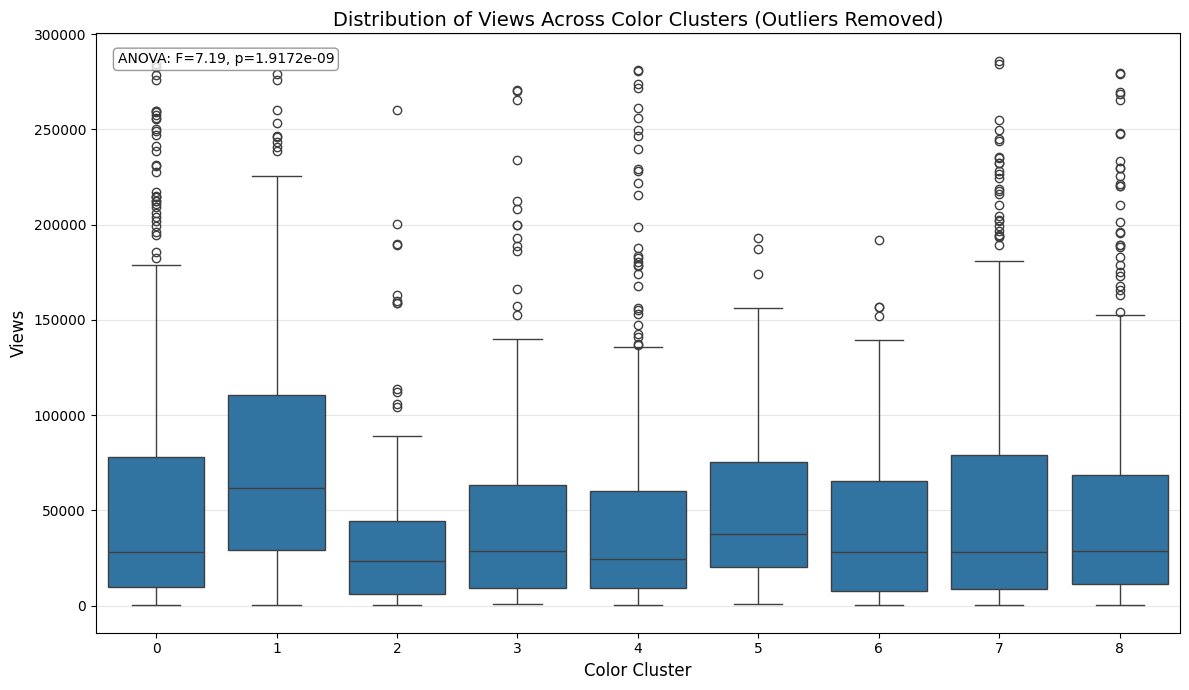

In [86]:
# Create boxplot for Views distribution by cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'])


# Style the plot
plt.title('Distribution of Views Across Color Clusters (Outliers Removed)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Views', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_result_views.statistic:.2f}, p={anova_result_views.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

In [87]:
# Perform ANOVA test on Likes (with outliers removed)
anova_result_likes = f_oneway(*likes_by_cluster)

# Print results
print("## ANOVA Results for Likes ##")
print(f"ANOVA F-statistic: {anova_result_likes.statistic:.4f}")
print(f"p-value: {anova_result_likes.pvalue:.4e}")

# Interpretation
if anova_result_likes.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Likes between color clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Likes between color clusters (p > {alpha}).")

## ANOVA Results for Likes ##
ANOVA F-statistic: 18.4657
p-value: 5.4951e-27
RESULT: There are statistically significant differences in Likes between color clusters (p < 0.05).


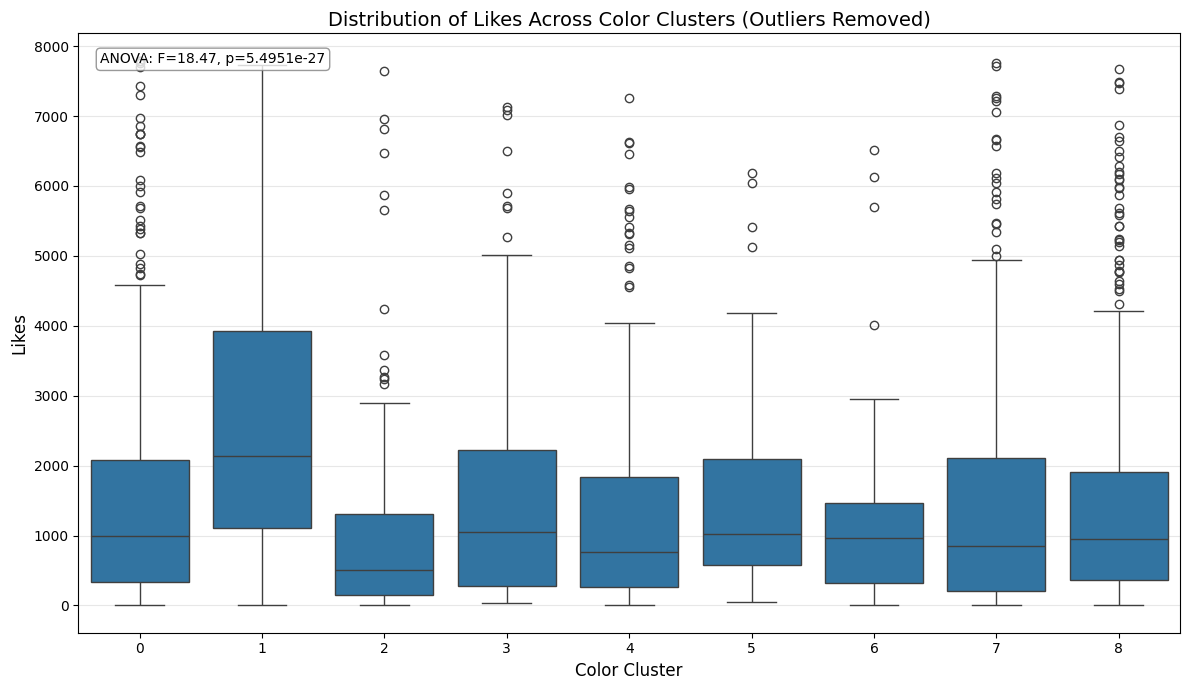

In [89]:
# Create boxplot for Likes distribution by cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'])


# Style the plot
plt.title('Distribution of Likes Across Color Clusters (Outliers Removed)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Likes', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_result_likes.statistic:.2f}, p={anova_result_likes.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

In [90]:
# Perform ANOVA test on Comments (with outliers removed)
anova_result_comments = f_oneway(*comments_by_cluster)

# Print results
print("## ANOVA Results for Comments ##")
print(f"ANOVA F-statistic: {anova_result_comments.statistic:.4f}")
print(f"p-value: {anova_result_comments.pvalue:.4e}")

# Interpretation
if anova_result_comments.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Comments between color clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Comments between color clusters (p > {alpha}).")

## ANOVA Results for Comments ##
ANOVA F-statistic: 5.7015
p-value: 3.3635e-07
RESULT: There are statistically significant differences in Comments between color clusters (p < 0.05).


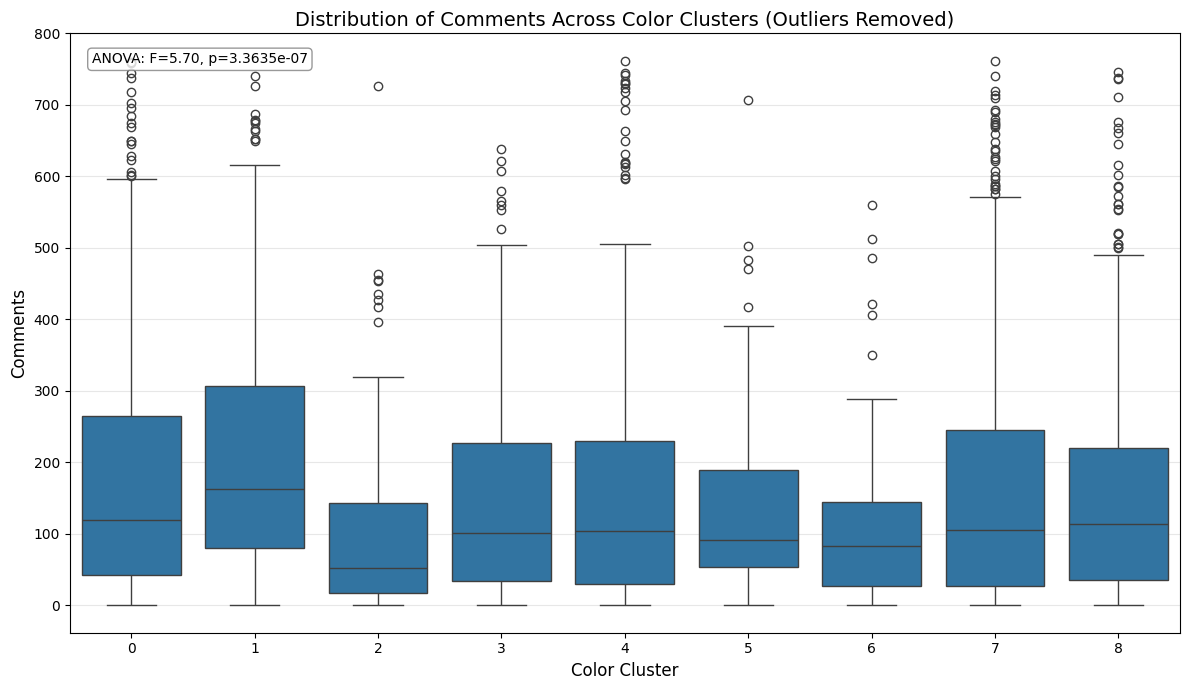

In [91]:
# Create boxplot for Comments distribution by cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'])

# Style the plot
plt.title('Distribution of Comments Across Color Clusters (Outliers Removed)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Comments', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_result_comments.statistic:.2f}, p={anova_result_comments.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()